In [2]:
# Import necessary libraries
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
# Load the dataset
from load_data import load_data_from_postgres

In [4]:
# Define your SQL query
query = "SELECT * FROM xdr_data;" # Replace with your actual table name.

# Load data from PostgreSQL
df = load_data_from_postgres(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data.")
else:
    print("Failed to load data.")

c:\Users\biement fanteye\Desktop\TelloCello\scripts\load_data.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data.


In [5]:
# Task 3.1: Aggregate per customer, handling missing values and outliers
# Replace missing values with the mean for numeric columns and mode for categorical columns
df['TCP DL Retrans. Vol (Bytes)'] = df['TCP DL Retrans. Vol (Bytes)'].fillna(df['TCP DL Retrans. Vol (Bytes)'].mean())
df['Avg RTT DL (ms)'] = df['Avg RTT DL (ms)'].fillna(df['Avg RTT DL (ms)'].mean())
df['Avg Bearer TP DL (kbps)'] = df['Avg Bearer TP DL (kbps)'].fillna(df['Avg Bearer TP DL (kbps)'].mean())
df['Handset Type'] = df['Handset Type'].fillna(df['Handset Type'].mode()[0])
# Convert MSISDN/Number to string to prevent scientific notation issues
df['MSISDN/Number'] = df['MSISDN/Number'].astype(str)

# Remove any leading/trailing spaces in case there are formatting issues
df['MSISDN/Number'] = df['MSISDN/Number'].str.strip()

# Now, group by customer (MSISDN/Number) and aggregate
aggregated_data = df.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Handset Type': 'first',
    'Avg Bearer TP DL (kbps)': 'mean'
}).reset_index()

# Display the result to verify
print(aggregated_data.head())

     MSISDN/Number  TCP DL Retrans. Vol (Bytes)  Avg RTT DL (ms)  \
0  3197020876596.0                 2.080991e+07       109.795706   
1    33601001722.0                 2.080991e+07        46.000000   
2    33601001754.0                 2.080991e+07        30.000000   
3    33601002511.0                 2.080991e+07       109.795706   
4    33601007832.0                 1.066000e+03        69.000000   

                       Handset Type  Avg Bearer TP DL (kbps)  
0  Quectel Wireless. Quectel Ec25-E                      1.0  
1    Huawei P20 Lite Huawei Nova 3E                     37.0  
2            Apple iPhone 7 (A1778)                     48.0  
3                         undefined                     48.0  
4           Apple iPhone 5S (A1457)                    204.0  


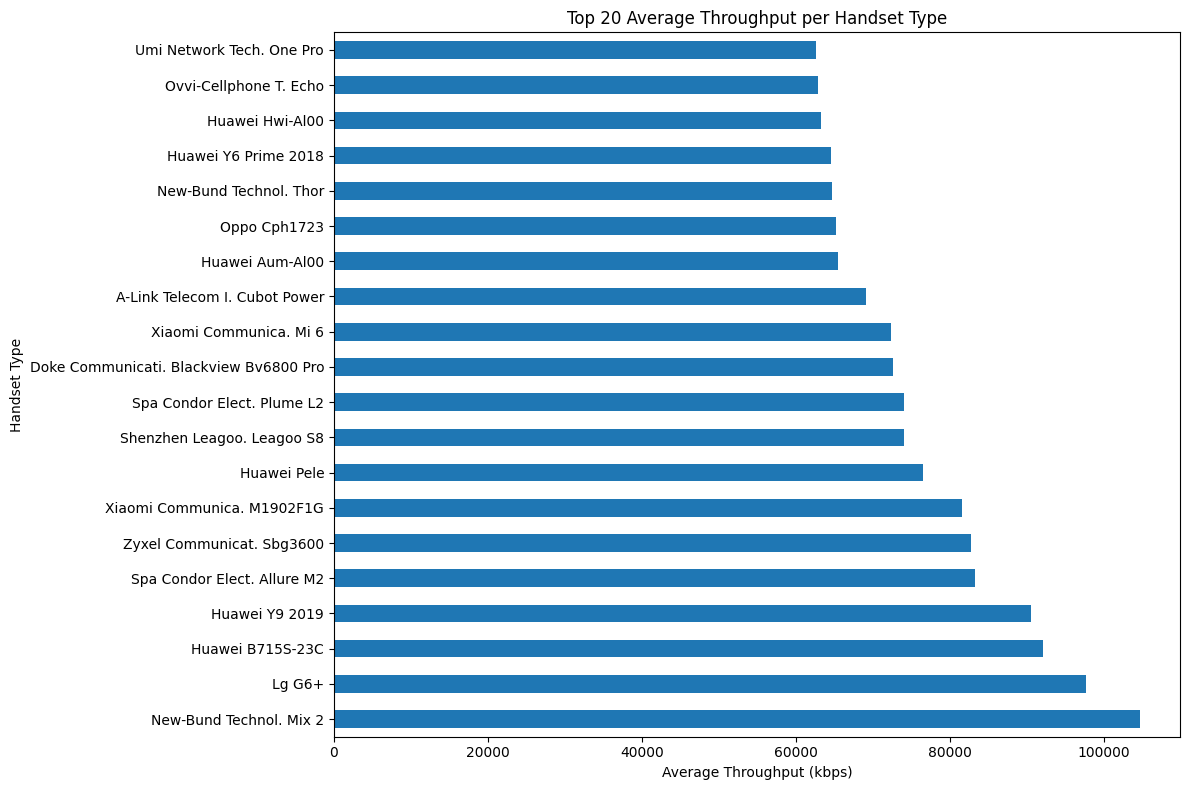

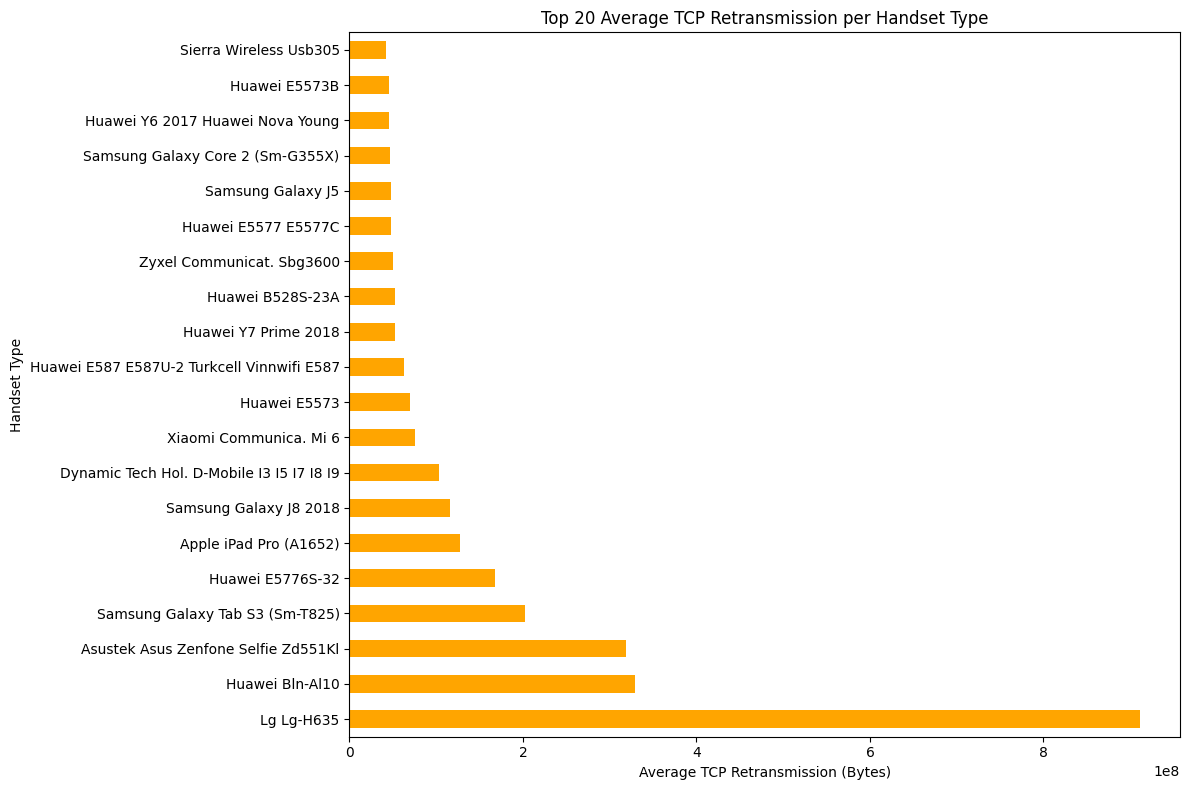

In [17]:
# Task 3.3: Distribution of Average Throughput & TCP Retransmission per Handset Type

# Distribution of average throughput per handset type
throughput_per_handset = df.groupby('Handset Type')['Avg Bearer TP DL (kbps)'].mean()

# Sort by throughput for better readability
throughput_per_handset_sorted = throughput_per_handset.sort_values(ascending=False)

# Limit to top 20 handsets for clarity
top_20_throughput = throughput_per_handset_sorted.head(20)

# Plot throughput distribution (horizontal bar plot)
plt.figure(figsize=(12, 8))
top_20_throughput.plot(kind='barh', title='Top 20 Average Throughput per Handset Type')
plt.xlabel('Average Throughput (kbps)')
plt.ylabel('Handset Type')
plt.tight_layout()  # Ensure layout fits
plt.show()

# Distribution of average TCP retransmission per handset type
tcp_per_handset = df.groupby('Handset Type')['TCP DL Retrans. Vol (Bytes)'].mean()

# Sort by retransmission volume
tcp_per_handset_sorted = tcp_per_handset.sort_values(ascending=False)

# Limit to top 20 handsets for clarity
top_20_tcp = tcp_per_handset_sorted.head(20)

# Plot TCP retransmission distribution (horizontal bar plot)
plt.figure(figsize=(12, 8))
top_20_tcp.plot(kind='barh', color='orange', title='Top 20 Average TCP Retransmission per Handset Type')
plt.xlabel('Average TCP Retransmission (Bytes)')
plt.ylabel('Handset Type')
plt.tight_layout()  # Ensure layout fits
plt.show()

In [18]:
# Task 3.4: K-Means Clustering
# Prepare data for clustering (using relevant features)
cluster_data = aggregated_data[['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']]

# Normalize the data
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Apply K-Means Clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
aggregated_data['Cluster'] = kmeans.fit_predict(cluster_data_scaled)

# Interpret clusters
for cluster in range(3):
    print(f"Cluster {cluster}:")
    print(aggregated_data[aggregated_data['Cluster'] == cluster].describe())

Cluster 0:
       TCP DL Retrans. Vol (Bytes)  Avg RTT DL (ms)  Avg Bearer TP DL (kbps)  \
count                 1.824100e+04     18241.000000             18241.000000   
mean                  1.959943e+07        77.317920             49175.254457   
std                   7.769324e+07       112.748338             22735.065947   
min                   3.100000e+01        15.000000             25526.666667   
25%                   5.241635e+05        40.666667             33398.000000   
50%                   3.686250e+06        56.000000             42627.000000   
75%                   1.133288e+07        80.250000             57500.000000   
max                   1.118514e+09      5379.000000            264448.000000   

       Cluster  
count  18241.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0  
Cluster 1:
       TCP DL Retrans. Vol (Bytes)  Avg RTT DL (ms)  Avg Bearer TP DL (kbps)  \
count                 8.